## Корреляции с лагом для сравнения с GDP

In [1]:
import pandas as pd
import datetime
import numpy as np
from statsmodels.tsa.stattools import ccf

from IPython.display import Image
from utils import crosscorr

import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import dickey_fuller_test, bkxg_filter, hodrick_prescott_filter

import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
data = pd.read_excel("data/Macro_data.xlsx")

### Take only needed columns

In [3]:
# needed_columns = ["GDP Real", "Private Consumtion", "GDP Deflator","CPI, Index", "Changes in inventories", "Investments"]
# data = data[["TIME"] + needed_columns].copy()
# пока просто отберём все и построим по всем
needed_columns = [col for col in data.columns.values if col!="TIME"]


### Take filters

In [4]:
for column in needed_columns:
    # считаем с логфрифмом(лучше сходится со статьей)
    data[f"{column}_ln_filtered"] = bkxg_filter(np.log(data[column]), (6, 40, 8))
    # без логарифма
    # data[f"{column}_ln_filtered"] = bkxg_filter(data[column], (6, 40, 8))
columns_filtered = [col for col in data.columns.values if 'filtered' in col]


### Function to count lag correlations with lag [-4, 4]

In [5]:
def count_range_of_corrs(data, xlabel, ylabel):
    corrs = []
    for lag in range(-4, 5):
        corrs.append(crosscorr(data[xlabel], data[ylabel], lag = lag))
    return corrs

### Find relative and absolute stds

In [6]:
def get_stds_dataframe(data, columns_filtered):
    std_absolute = []
    std_relative = []
    for column in columns_filtered:
        std_absolute.append(data[column].std())
        std_relative.append((data[column]/data["GDP Real_ln_filtered"]).std())
    stds_df = pd.DataFrame({"index": columns_filtered, "std_absolute": std_absolute, "std_relative": std_relative})
    stds_df["index"] = stds_df["index"].str.split("_").str[0]

    return stds_df

In [7]:
stds_df = get_stds_dataframe(data, columns_filtered)

### Build table

In [8]:
results = []

for col in columns_filtered:
    ser = pd.Series(count_range_of_corrs(data, 'GDP Real_ln_filtered', col), name = col, index = range(-4, 5))
    results.append(ser)

final_table = pd.concat(results, axis=1).T.reset_index()
final_table["index"] = final_table["index"].str.split("_").str[0]
# клеим std
final_table = stds_df.merge(final_table, on = "index").round(2)

col_names = ["std_absolute", "std_relative"] + list(zip(['Cross correlation with GDP(t+k)' for i in range(9)], list(range(-4, 5))))
final_table.index = final_table["index"]
final_table = final_table.drop(columns = "index")
final_table.index.name = 'variables(t)'

final_table


,std_absolute,std_relative,-4,-3,-2,-1,0,1,2,3,4
variables(t),,,,,,,,,,,
GDP Nominal,0.01,3.01,-0.09,0.20,0.52,0.77,0.83,0.69,0.38,0.00,-0.34
GDP Real,0.01,0.00,-0.07,0.27,0.62,0.90,1.00,0.90,0.62,0.27,-0.07
Private Consumtion,0.01,3.95,-0.18,-0.02,0.23,0.48,0.64,0.64,0.48,0.22,-0.07
Investments,0.06,13.93,-0.06,0.32,0.67,0.89,0.93,0.76,0.47,0.13,-0.14
Residential,0.08,37.78,-0.34,-0.12,0.19,0.50,0.74,0.85,0.80,0.62,0.38
Non-Residential,0.03,16.37,0.45,0.71,0.84,0.80,0.60,0.27,-0.08,-0.36,-0.53
Changes in inventories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cumulated Chnge in iventories,0.08,31.19,0.74,0.88,0.86,0.66,0.34,0.06,-0.17,-0.29,-0.30
Total export,0.04,47.49,0.33,0.40,0.40,0.31,0.14,-0.09,-0.31,-0.48,-0.58


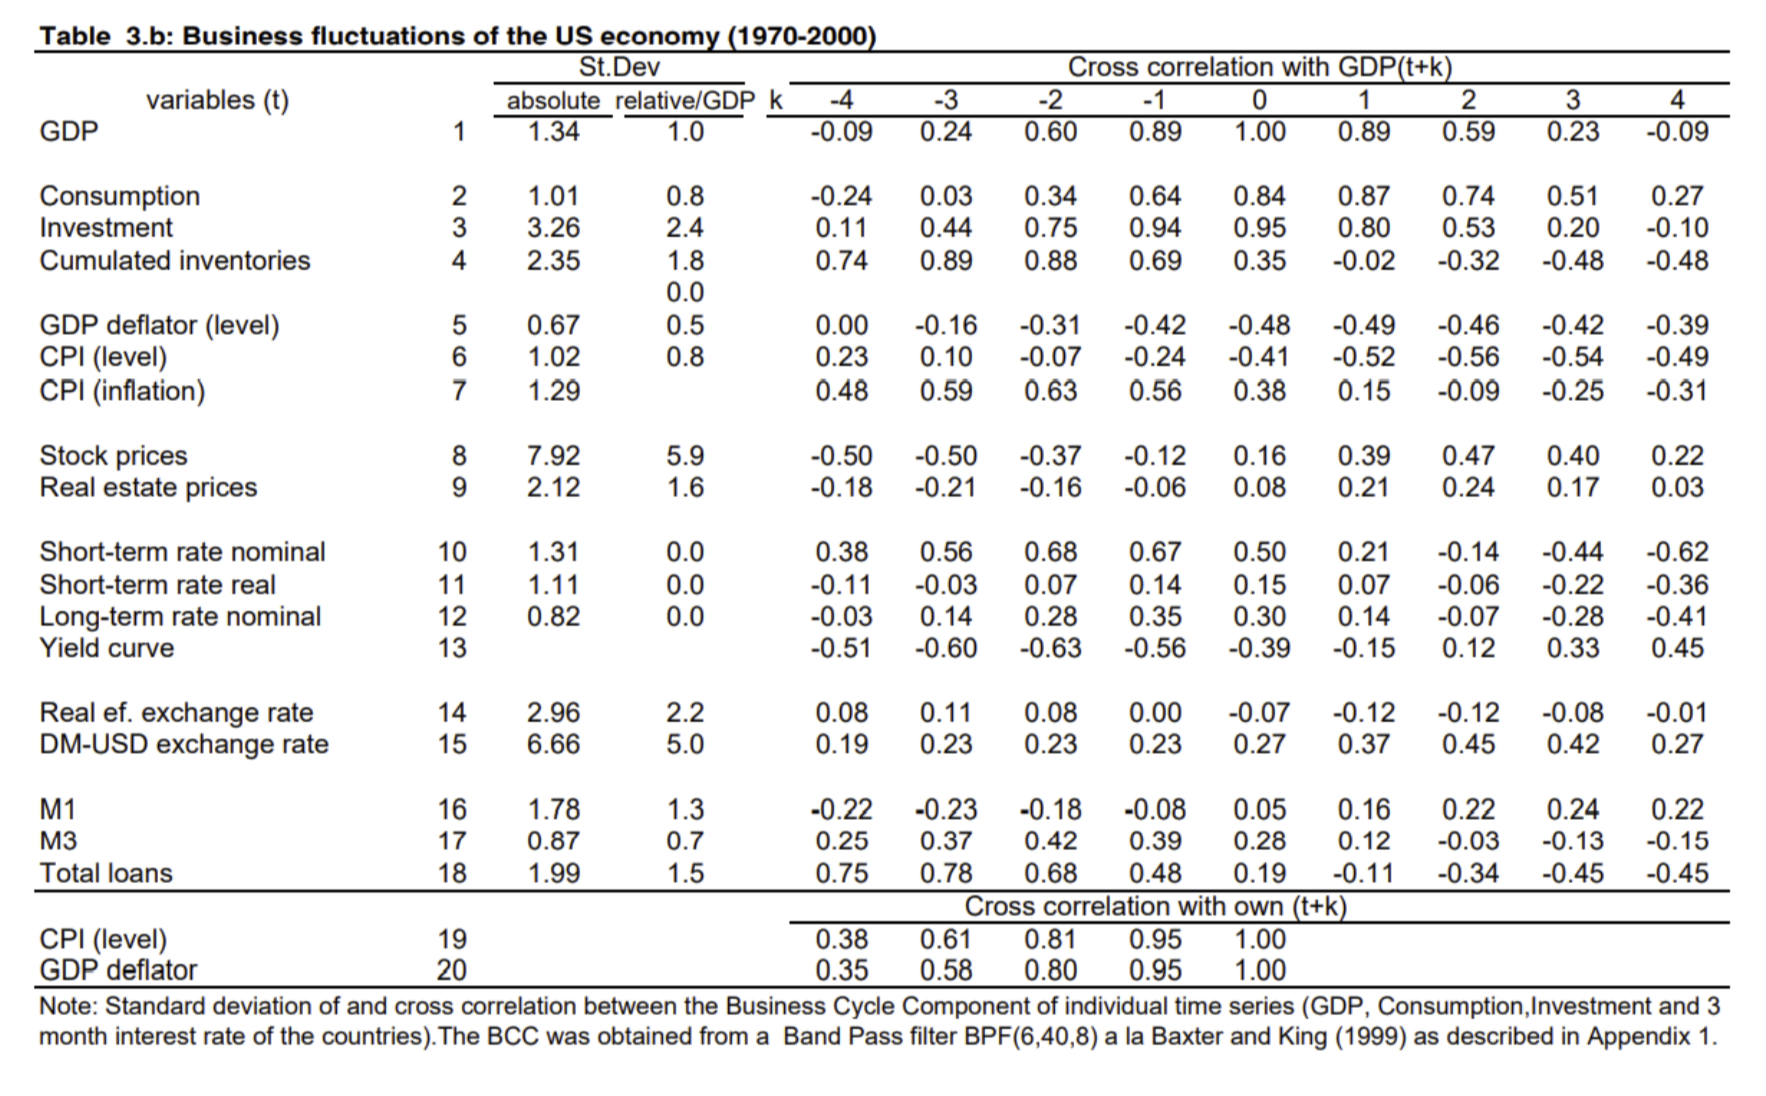

In [9]:
Image(filename = "img/lag_corrs.png")
